# 《GPS追踪还原罐车轨迹，食品安全问题再现！》源代码
https://blog.renhai.online/archives/oil-tank-truck-food-safety-gps-tracking-example

## 导入数据

In [1]:
import pandas as pd
import geopandas as gpd

path = r"Y:\downloads\others\数据集\深圳城市数据-手机信令-公交卡-出租车-巴士-卡车GPS数据---城市数据发布V2\TaxiData.txt"

df = pd.read_csv(path, 
                 delimiter=',', 
                 lineterminator='\n', 
                 header=None,
                 names=['VehicleNum', 'Time', 'Lng', 'Lat', 'OccupancyStatus', 'Speed'])
df.head()

c:\Users\hncdj\anaconda3\envs\movingpandas-dev\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,VehicleNum,Time,Lng,Lat,OccupancyStatus,Speed
0,22223,21:09:38,114.138535,22.609266,1,19
1,22223,11:14:18,114.137871,22.575317,0,0
2,22223,01:18:28,114.137131,22.575983,0,0
3,22223,13:11:42,114.136269,22.545851,1,18
4,22223,02:05:47,114.135948,22.578917,0,29


In [10]:
import movingpandas as mpd

mpd.show_versions()


MovingPandas 0.18.1

SYSTEM INFO
-----------
python     : 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:40:08) [MSC v.1938 64 bit (AMD64)]
executable : c:\Users\hncdj\anaconda3\envs\movingpandas-dev\python.exe
machine    : Windows-10-10.0.22621-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.9.1
GDAL data dir: None
PROJ       : 9.4.0
PROJ data dir: C:\Users\hncdj\anaconda3\envs\movingpandas-dev\Library\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 1.0.1
pandas     : 2.2.2
fiona      : 1.9.6
numpy      : 1.26.4
shapely    : 2.0.4
rtree      : 1.3.0
pyproj     : 3.6.1
matplotlib : 3.9.1
mapclassify: 2.6.1
geopy      : 2.4.1
holoviews  : 1.19.1
hvplot     : 0.10.0
geoviews   : 1.12.0
stonesoup  : 1.3


## 随机选出某一辆车的数据

In [2]:
# 随机选出某一辆车的数据
total_taixs = df.VehicleNum.unique()
taixs_id = total_taixs[0]
print(taixs_id)

# 读取样本
df_sample = df[df.VehicleNum == taixs_id]

# 清除原始df占用的内存
del df

# 我们只需要出某辆车的数据 所以可以简单的处理时间 
df_sample.loc[:, 'DateTime'] = '2013-10-22 ' + df_sample['Time']

# 排序
df_sample = df_sample.sort_values(by='Time')
df_sample = df_sample.drop(columns=['Time'])
df_sample = df_sample.reset_index(drop=True)

df_sample.head()

22223


,VehicleNum,Lng,Lat,OccupancyStatus,Speed,DateTime
0,22223,114.145714,22.555317,1,80,2013-10-22 00:00:00
1,22223,114.146950,22.555468,1,80,2013-10-22 00:00:06
2,22223,114.148537,22.555866,1,80,2013-10-22 00:00:14
3,22223,114.148949,22.555933,1,79,2013-10-22 00:00:16
4,22223,114.150200,22.556116,1,84,2013-10-22 00:00:22


In [3]:
df_sample

,VehicleNum,Lng,Lat,OccupancyStatus,Speed,DateTime
0,22223,114.145714,22.555317,1,80,2013-10-22 00:00:00
1,22223,114.146950,22.555468,1,80,2013-10-22 00:00:06
2,22223,114.148537,22.555866,1,80,2013-10-22 00:00:14
3,22223,114.148949,22.555933,1,79,2013-10-22 00:00:16
4,22223,114.150200,22.556116,1,84,2013-10-22 00:00:22
...,...,...,...,...,...,...
2577,22223,114.101318,22.547968,1,0,2013-10-22 23:53:18
2578,22223,114.101486,22.547934,1,0,2013-10-22 23:53:33
2579,22223,114.101501,22.547899,0,0,2013-10-22 23:53:49
2580,22223,114.101646,22.547800,0,5,2013-10-22 23:54:04


2582条数据，1天的数据

In [4]:
df_sample.Speed.describe()

count    2582.000000
mean       30.813710
std        26.462663
min         0.000000
25%         0.000000
50%        29.000000
75%        54.000000
max        90.000000
Name: Speed, dtype: float64

In [5]:
# 保存
df_sample.to_csv("./data/taix-traj-sample.csv", index=False, header=True)
# 读取
df_sample = pd.read_csv("./data/taix-traj-sample.csv", header=0)

可以先根据数据进行分段也可以直接导入movingpandas

## 将这一辆车的轨迹转为movingpandas的Trajectory对象

In [6]:
tc = mpd.TrajectoryCollection(df_sample, 
                              'VehicleNum', 
                              t='DateTime', 
                              x='Lng', 
                              y='Lat')
tc

TrajectoryCollection with 1 trajectories

In [7]:
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':400, 'frame_width':700, 'cmap':'Viridis', 'colorbar':True}
tc.hvplot(title=str(tc), line_width=5, **hvplot_defaults)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

## Writing as points

In [8]:
point_gdf = tc.to_point_gdf()
point_gdf.head()

,VehicleNum,OccupancyStatus,Speed,geometry
DateTime,,,,
2013-10-22 00:00:00,22223,1,80,POINT (114.14571 22.55532)
2013-10-22 00:00:06,22223,1,80,POINT (114.14695 22.55547)
2013-10-22 00:00:14,22223,1,80,POINT (114.14854 22.55587)
2013-10-22 00:00:16,22223,1,79,POINT (114.14895 22.55593)
2013-10-22 00:00:22,22223,1,84,POINT (114.1502 22.55612)


<Axes: >

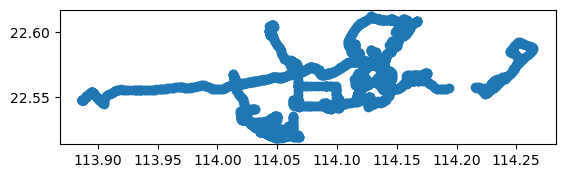

In [11]:
point_gdf.to_file("./data/temp.gpkg", layer='points', driver="GPKG")
gpd.read_file('./data/temp.gpkg', layer='points').plot()

## Writing as lines

In [12]:
line_gdf = tc.to_line_gdf()
line_gdf.head()

,VehicleNum,OccupancyStatus,Speed,t,prev_t,geometry
0,22223,1,80,2013-10-22 00:00:06,2013-10-22 00:00:00,"LINESTRING (114.14571 22.55532, 114.14695 22.5..."
1,22223,1,80,2013-10-22 00:00:14,2013-10-22 00:00:06,"LINESTRING (114.14695 22.55547, 114.14854 22.5..."
2,22223,1,79,2013-10-22 00:00:16,2013-10-22 00:00:14,"LINESTRING (114.14854 22.55587, 114.14895 22.5..."
3,22223,1,84,2013-10-22 00:00:22,2013-10-22 00:00:16,"LINESTRING (114.14895 22.55593, 114.1502 22.55..."
4,22223,1,81,2013-10-22 00:00:30,2013-10-22 00:00:22,"LINESTRING (114.1502 22.55612, 114.15182 22.5566)"


<Axes: >

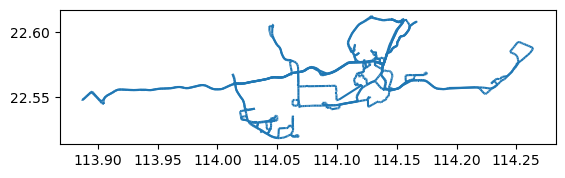

In [13]:
line_gdf.to_file("./data/temp.gpkg", layer='lines', driver="GPKG")
gpd.read_file('./data/temp.gpkg', layer='lines').plot()

## Writing as trajectories

In [14]:
traj_gdf = tc.to_traj_gdf(wkt=True)
traj_gdf

,VehicleNum,start_t,end_t,geometry,length,direction,wkt
0,22223,2013-10-22,2013-10-22 23:59:58,"LINESTRING (114.14571 22.55532, 114.14695 22.5...",287470.172364,278.783474,LINESTRING M (114.145714 22.555317 1382400000....


<Axes: >

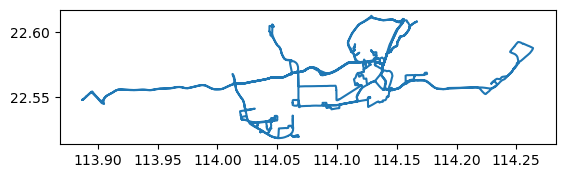

In [15]:
traj_gdf.to_file("./data/temp.gpkg", layer='trajectories', driver="GPKG")
gpd.read_file('./data/temp.gpkg', layer='trajectories').plot()

In [16]:
# 删除临时文件
import os

os.remove("./data/temp.gpkg")

In [19]:
# 自动计算速度速度
my_traj = tc.trajectories[0]
my_traj.add_speed(overwrite=True, name="speed (km/h)", units=("km", "h"))
my_traj.df.head()

,VehicleNum,OccupancyStatus,Speed,geometry,speed (km/h)
DateTime,,,,,
2013-10-22 00:00:00,22223,1,80,POINT (114.14571 22.55532),76.934426
2013-10-22 00:00:06,22223,1,80,POINT (114.14695 22.55547),76.934426
2013-10-22 00:00:14,22223,1,80,POINT (114.14854 22.55587),76.084374
2013-10-22 00:00:16,22223,1,79,POINT (114.14895 22.55593),77.437465
2013-10-22 00:00:22,22223,1,84,POINT (114.1502 22.55612),78.154410


In [23]:
my_traj.hvplot(c='speed (km/h)', clim=(0,120), line_width=7.0, tiles='CartoLight', cmap='Viridis', colorbar=True)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed (km/h))
   .Points.I :Points   [Longitude,Latitude]   (speed (km/h),triangle_angle)

In [22]:
# 获取某个时间点的近似位置
from datetime import datetime

# 获取开始和结束点
start_point = my_traj.get_start_location()
end_point = my_traj.get_end_location()
print(start_point, end_point)

some_time = datetime(2013, 10, 22, 12, 6, 0)
estimated_position = my_traj.get_position_at(some_time, method="nearest")
print(estimated_position)

POINT (114.145714 22.555317) POINT (114.120583 22.558901)
POINT (114.116417 22.546417)


In [25]:
import pprint
import folium
import geopandas as gpd


# 创建地图对象
m = folium.Map(location=[22.543096, 114.057865], zoom_start=12)

# 将轨迹数据转换为GeoDataFrame并处理时间戳
traj_gdf = my_traj.to_traj_gdf()
traj_gdf['start_t'] = traj_gdf['start_t'].astype(str)  # 将时间戳转换为字符串
traj_gdf['end_t'] = traj_gdf['end_t'].astype(str) 

# 将轨迹数据添加到地图上
# # 定义渐变颜色
# import branca.colormap as cm

# colormap = cm.LinearColormap(
#     colors=['#031ca6', '#049dd9', '#d97904', '#d91e1e'],
#     vmin=0, vmax=120,
#     caption='speed (km/h)'
# )


# # 定义分级着色的函数
# def style_function(feature):
#     speed = feature['properties'].get('speed (km/h)', 0)  # 获取速度属性，如果不存在则默认为0
#     return {'color': colormap(speed)}


# 添加轨迹数据到地图
folium.GeoJson(traj_gdf.to_json(), 
            #    style_function=style_function
               ).add_to(m)

# 添加开始点标记
folium.Marker(
    location=[start_point.y, start_point.x],
    popup=folium.Popup("Start Point", parse_html=True),
    icon=folium.Icon(color='red')
).add_to(m)

# 添加结束点标记
folium.Marker(
    location=[end_point.y, end_point.x],
    popup=folium.Popup("End Point", parse_html=True),
    icon=folium.Icon(color='green')
).add_to(m)

# 添加估计位置标记

folium.Marker(
    location=[estimated_position.y, estimated_position.x],
    popup=folium.Popup(f"Estimated Position\n {some_time.strftime('%H:%M')}", parse_html=True),
    icon=folium.Icon(color='blue')
).add_to(m)

# 保存地图到HTML文件
m.save("map.html")

# 显示地图
m


# 拆分
拆分规则在 30 米内停留至少 1 分钟的轨迹。丢弃长度小于 500 米的创建轨迹：

In [26]:
from datetime import timedelta

split = mpd.StopSplitter(my_traj).split(max_diameter=30, min_duration=timedelta(minutes=5), min_length=500)
split

TrajectoryCollection with 7 trajectories

In [27]:
split.to_traj_gdf()

,VehicleNum,start_t,end_t,geometry,length,direction
0,22223_2013-10-22 00:00:00,2013-10-22 00:00:00,2013-10-22 02:09:32,"LINESTRING (114.14571 22.55532, 114.14695 22.5...",70433.815989,336.957868
1,22223_2013-10-22 06:21:42,2013-10-22 06:21:42,2013-10-22 06:29:06,"LINESTRING (114.13187 22.57962, 114.13088 22.5...",2744.707642,288.415199
2,22223_2013-10-22 06:43:36,2013-10-22 06:43:36,2013-10-22 07:39:05,"LINESTRING (114.11806 22.5837, 114.11802 22.58...",39391.892646,260.444047
3,22223_2013-10-22 10:16:21,2013-10-22 10:16:21,2013-10-22 10:49:16,"LINESTRING (113.88752 22.54787, 113.88802 22.5...",27862.049542,83.176934
4,22223_2013-10-22 11:04:16,2013-10-22 11:04:16,2013-10-22 13:17:44,"LINESTRING (114.13188 22.57455, 114.13187 22.5...",53376.453891,150.648801
5,22223_2013-10-22 20:26:04,2013-10-22 20:26:04,2013-10-22 20:50:18,"LINESTRING (114.14404 22.55468, 114.14404 22.5...",9385.459132,1.329460
6,22223_2013-10-22 21:07:14,2013-10-22 21:07:14,2013-10-22 23:59:58,"LINESTRING (114.1454 22.60962, 114.14498 22.60...",82696.738811,204.319497


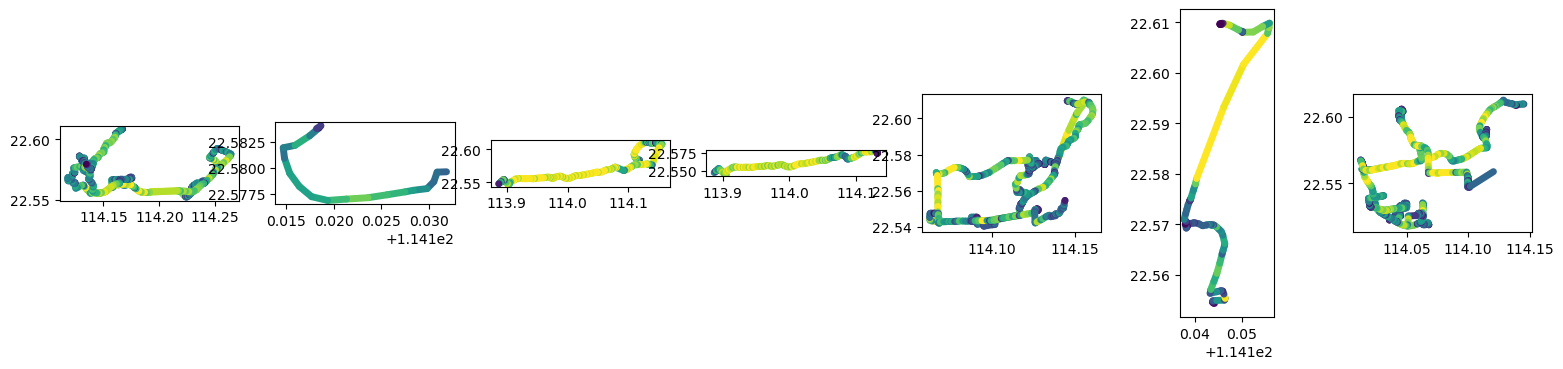

In [28]:
import matplotlib.pyplot as plt
import hvplot.pandas 

fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

In [30]:
# 画图
import folium
from datetime import datetime, timedelta
import geopandas as gpd
import movingpandas as mpd
from folium.plugins import Draw

# 获取开始和结束点
start_point = my_traj.get_start_location()
end_point = my_traj.get_end_location()

# 获取某个时间点的近似位置
some_time = datetime(2013, 10, 22, 12, 6, 0)
estimated_position = my_traj.get_position_at(some_time, method="nearest")

# 创建地图对象
m = folium.Map(location=[22.543096, 114.057865], zoom_start=12)

# 拆分轨迹
split = mpd.StopSplitter(my_traj).split(max_diameter=30, min_duration=timedelta(minutes=5), min_length=500)

# 将拆分后的轨迹数据添加到地图上
for i, traj in enumerate(split):
    traj_gdf = traj.to_traj_gdf()
    # print("{i}_traj_gdf:", traj_gdf)
    traj_gdf['start_t'] = traj_gdf['start_t'].astype(str)  # 将时间戳转换为字符串
    traj_gdf['end_t'] = traj_gdf['end_t'].astype(str)
    folium.GeoJson(traj_gdf.to_json(), 
                #    style_function=style_function
                   ).add_to(m)

# 添加开始点标记
folium.Marker(
    location=[start_point.y, start_point.x],
    popup=folium.Popup("Start Point", parse_html=True),
    icon=folium.Icon(color='red')
).add_to(m)

# 添加结束点标记
folium.Marker(
    location=[end_point.y, end_point.x],
    popup=folium.Popup("End Point", parse_html=True),
    icon=folium.Icon(color='green')
).add_to(m)

# 添加估计位置标记
folium.Marker(
    location=[estimated_position.y, estimated_position.x],
    popup=folium.Popup(f"Estimated Position\n {some_time.strftime('%H:%M')}", parse_html=True),
    icon=folium.Icon(color='blue')
).add_to(m)

# 启用绘图插件
draw = Draw(
    export=True,
    draw_options={
        'polyline': True,
        'polygon': True,
        'circle': True,
        'rectangle': True,
        'marker': True,
        'circlemarker': False
    },
    edit_options={
        'edit': True,
        'remove': True
    }
)
m.add_child(draw)

# 保存地图到HTML文件
m.save("taix_map_splits.html")


# 显示地图
m


### 通过位置提取轨迹

                                            geometry
0  POLYGON ((113.96187 22.53856, 113.96187 22.587...


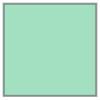

In [32]:
# 获取绘制的数据
dict = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[113.961868,22.538562],[113.961868,22.587069],[114.01062,22.587069],[114.01062,22.538562],[113.961868,22.538562]]]}}]}
gdf = gpd.GeoDataFrame.from_features(dict)
print(gdf)

from shapely import Polygon

polygon = gdf.geometry[0]
polygon

In [33]:
print(polygon)

POLYGON ((113.961868 22.538562, 113.961868 22.587069, 114.01062 22.587069, 114.01062 22.538562, 113.961868 22.538562))


In [34]:
intersections = my_traj.clip(polygon)
intersections

TrajectoryCollection with 2 trajectories

<Axes: >

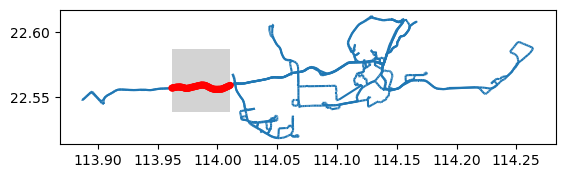

In [35]:
ax = my_traj.plot()
gpd.GeoSeries(polygon).plot(ax=ax, color='lightgray')
intersections.plot(ax=ax, color='red', linewidth=5, capstyle='round')